# Warehouse Allocation and Assignment
*This notebook illustrates how to assess the inventory position of a storage system.
*Use the virtual environment logproj.yml to run this notebook.*
***
Alessandro Tufano 2020

### Import packages

In [1]:
# %% append functions path
import sys; sys.path.insert(0, '..') #add the above level with the package

import pandas as pd
import numpy as np

from IPython.display import display, HTML #display dataframe

#import utilities
from logproj.utilities import creaCartella

### Set data fields

In [2]:
string_casestudy = 'TOY_DATA'

### Import data

In [3]:
# %% import data
from logproj.data_generator_warehouse import generateWarehouseData
D_locations, D_SKUs, D_movements, D_inventory = generateWarehouseData()


In [4]:
#print locations dataframe
display(HTML(D_locations.head().to_html()))

,NODECODE,IDWH,WHSUBAREA,IDLOCATION,LOCCODEX,LOCCODEY,LOCCODEZ,RACK,BAY,LEVEL
0,1,FAKE,AREA 1,1,0,0,0,0,0,0
0,1,LOGICAL_WH1,AREA 1,2,0,0,1200,0,0,1
0,1,LOGICAL_WH2,AREA 1,3,0,0,2400,0,0,2
0,1,LOGICAL_WH1,AREA 1,4,0,0,3600,0,0,3
0,1,FAKE,AREA 1,5,0,0,4800,0,0,4


In [5]:
#print SKUs master file dataframe
display(HTML(D_SKUs.head().to_html()))

,ITEMCODE,DESCRIPTION,VOLUME,WEIGHT
0,0,PRODOTTO_0,73.804672,7.413359
0,1,PRODOTTO_1,87.355541,7.338134
0,2,PRODOTTO_2,25.833440,4.439065
0,3,PRODOTTO_3,15.117716,2.525654
0,4,PRODOTTO_4,89.044568,5.276363


In [6]:
#print SKUs master file dataframe
display(HTML(D_movements.head().to_html()))

,ITEMCODE,NODECODE,IDWH,WHSUBAREA,IDLOCATION,RACK,BAY,LEVEL,LOCCODEX,LOCCODEY,LOCCODEZ,ORDERCODE,PICKINGLIST,QUANTITY,VOLUME,WEIGHT,TIMESTAMP_IN,INOUT,ORDERTYPE
0,91,1,FAKE,AREA 1,1356,4,7,0,16000,5600,0,207,207,3.306453,230.395867,12.579741,2020-01-02 00:27:40.455087,-,PUTAWAY
0,34,1,LOGICAL_WH2,AREA 1,1464,4,28,3,16000,22400,3600,31,31,9.618469,9.188239,95.130213,2020-01-02 00:53:31.595325,-,PUTAWAY
0,85,1,LOGICAL_WH2,AREA 1,269,0,53,3,0,42400,3600,151,151,20.863071,1239.166474,106.536791,2020-01-02 01:19:54.166501,+,PICKING
0,6,1,LOGICAL_WH2,AREA 1,506,1,35,0,4000,28000,0,677,677,4.834675,418.238427,23.307804,2020-01-02 02:25:24.897064,-,OTHER
0,16,1,FAKE,AREA 1,253,0,50,2,0,40000,2400,97,97,40.601952,2708.641324,28.074119,2020-01-02 02:51:32.992226,-,OTHER


In [7]:
#print SKUs master file dataframe
display(HTML(D_inventory.head().to_html()))

,NODECODE,IDWH,ITEMCODE,IDLOCATION,QUANTITY,TIMESTAMP
0,1,FAKE,0,651,8.004978,2020-01-02
0,1,LOGICAL_WH1,1,574,3.088484,2020-01-02
0,1,FAKE,2,1213,1.494114,2020-01-02
0,1,LOGICAL_WH2,3,1605,12.410642,2020-01-02
0,1,LOGICAL_WH2,4,849,3.095897,2020-01-02


### Create folder hierarchy

In [8]:
# %% create folder hierarchy
pathResults = 'C:\\Users\\aletu\\desktop'
_, root_path = creaCartella(pathResults,f"{string_casestudy}_results")
_, path_results = creaCartella(root_path,f"P8_warehouseAssessment")

Cartella TOY_DATA_results già esistente
Cartella P8_warehouseAssessment già esistente


### Set the columns name

In [9]:
# %% SET COLUMNS MOVEMENTS
timecolumn_mov='TIMESTAMP_IN'
itemcodeColumns_mov='ITEMCODE'
inout_column_mov = 'INOUT'
x_col_mov = 'LOCCODEX'
y_col_mov = 'LOCCODEY'
z_col_mov = 'LOCCODEZ'

In [10]:
# %% SET COLUMNS SKUS
itemcodeColumns_sku='ITEMCODE'

In [11]:
# %% SET COLUMNS INVENTORY
itemcodeColumns_inv = 'ITEMCODE'

### Calculate storage space allocation fractions

In [12]:
# %% ALLOCATION EQS, EQT, OPT
_, path_current = creaCartella(path_results,f"Allocation")

from logproj.P5_powerProblem.warehouseAllocation import AllocateSKUs

D_allocation = AllocateSKUs(D_movements, D_SKUs)
D_allocation.to_excel(path_current+"\\allocation continuous.xlsx")

Cartella Allocation già esistente


In [13]:
#print SKUs allocation table
display(HTML(D_allocation.head().to_html()))

,ITEMCODE,QUANTITY,DESCRIPTION,VOLUME,WEIGHT,fi,EQS,EQT,OPT
0,0,169.504015,PRODOTTO_0,73.804672,7.413359,12510.188175,0.01,0.021351,0.016378
1,1,53.278661,PRODOTTO_1,87.355541,7.338134,4654.186235,0.01,0.007943,0.009990
2,2,41.379605,PRODOTTO_2,25.833440,4.439065,1068.977534,0.01,0.001824,0.004788
3,3,78.567865,PRODOTTO_3,15.117716,2.525654,1187.766682,0.01,0.002027,0.005047
4,4,40.379290,PRODOTTO_4,89.044568,5.276363,3595.556484,0.01,0.006136,0.008780


### Calculate discrete storage allocation (N. of SKUs)

In [14]:
# %% DISCRETE ALLOCATION
from logproj.P5_powerProblem.warehouseAllocation import discreteAllocationParts

availableSpacedm3 = 10000 #available space in dm3
for method in ['EQS', 'EQT', 'OPT']:
    D_allocated = discreteAllocationParts(D_allocation, availableSpacedm3, method='OPT')
    D_allocated.to_excel(path_current+f"\\discrete allocation {method}.xlsx")

In [15]:
#print SKUs allocation table
display(HTML(D_allocated.head().to_html()))

,ITEMCODE,QUANTITY,DESCRIPTION,VOLUME,WEIGHT,fi,EQS,EQT,OPT,ALLOCATED_VOLUME,N_PARTS_OPT
0,0,169.504015,PRODOTTO_0,73.804672,7.413359,12510.188175,0.01,0.021351,0.016378,163.780298,2.0
1,1,53.278661,PRODOTTO_1,87.355541,7.338134,4654.186235,0.01,0.007943,0.009990,99.896809,1.0
2,2,41.379605,PRODOTTO_2,25.833440,4.439065,1068.977534,0.01,0.001824,0.004788,47.875577,2.0
3,3,78.567865,PRODOTTO_3,15.117716,2.525654,1187.766682,0.01,0.002027,0.005047,50.465584,3.0
4,4,40.379290,PRODOTTO_4,89.044568,5.276363,3595.556484,0.01,0.006136,0.008780,87.803695,1.0


### Assignment of SKUs to storage locations

In [16]:
# prepare data for storage assignment
from logproj.P6_placementProblem.warehouse_graph_definition import prepareCoordinates

_, path_current = creaCartella(path_results,f"Assignment")

#prepare input table locations
D_layout, D_IO, D_fake,  allLocs = prepareCoordinates(D_locations)
D_layout['aislecodex'] =np.nan 

display(HTML(D_layout.head().to_html()))

Cartella Assignment già esistente
=======Input point unmapped. I is set to x:8000.0,y:-1
=======Output point unmapped. O is set to x:8000.0,y:-1


,nodecode,idwh,whsubarea,idlocation,loccodex,loccodey,loccodez,rack,bay,level,aislecodex
0,1,FAKE,AREA 1,1,0,0,0,0,0,0,NaN
0,1,LOGICAL_WH1,AREA 1,2,0,0,1200,0,0,1,NaN
0,1,LOGICAL_WH2,AREA 1,3,0,0,2400,0,0,2,NaN
0,1,LOGICAL_WH1,AREA 1,4,0,0,3600,0,0,3,NaN
0,1,FAKE,AREA 1,5,0,0,4800,0,0,4,NaN


In [17]:
from logproj.P6_placementProblem.warehouse_graph_definition import calculateStorageLocationsDistance, extractIoPoints
D_loc = D_layout.append(D_IO)
D_loc.columns=[i.upper() for i in D_loc.columns ]
input_loccodex, input_loccodey, output_loccodex, output_loccodey = extractIoPoints(D_loc)
D_loc=calculateStorageLocationsDistance(D_loc,input_loccodex, input_loccodey, output_loccodex, output_loccodey)
display(HTML(D_loc.head().to_html()))

,NODECODE,IDWH,WHSUBAREA,IDLOCATION,LOCCODEX,LOCCODEY,LOCCODEZ,RACK,BAY,LEVEL,AISLECODEX,INPUTLOC,OUTPUTLOC,INPUT_DISTANCE,OUTPUT_DISTANCE
0,1.0,FAKE,AREA 1,1,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,8001,8001
0,1.0,LOGICAL_WH1,AREA 1,2,0.0,0,1200,0.0,0.0,1.0,NaN,NaN,NaN,8001,8001
0,1.0,LOGICAL_WH2,AREA 1,3,0.0,0,2400,0.0,0.0,2.0,NaN,NaN,NaN,8001,8001
0,1.0,LOGICAL_WH1,AREA 1,4,0.0,0,3600,0.0,0.0,3.0,NaN,NaN,NaN,8001,8001
0,1.0,FAKE,AREA 1,5,0.0,0,4800,0.0,0.0,4.0,NaN,NaN,NaN,8001,8001


### Set ABC classes of storage locations

In [18]:
# %% set Pareto cuts of the A and B classes
AclassPerc = 0.20
BclassPerc = 0.50

from logproj.P2_assignmentProblem.warehousing_ABC_saving import defineABCclassesOfStorageLocations 

D_loc = defineABCclassesOfStorageLocations(D_loc, AclassPerc=AclassPerc, BclassPerc=BclassPerc)
D_loc.to_excel(path_current+f"\\locations assignment.xlsx")
display(HTML(D_loc.head().to_html()))

,NODECODE,IDWH,WHSUBAREA,IDLOCATION,LOCCODEX,LOCCODEY,LOCCODEZ,RACK,BAY,LEVEL,AISLECODEX,INPUTLOC,OUTPUTLOC,INPUT_DISTANCE,OUTPUT_DISTANCE,WEIGHT,WEIGHT_cum,CLASS
0,1.0,FAKE,AREA 1,330,0.0,52000,4800,0.0,65.0,4.0,NaN,NaN,NaN,60001,60001,0.00118062,0.00118062,A
0,1.0,LOGICAL_WH2,AREA 1,1650,16000.0,52000,4800,4.0,65.0,4.0,NaN,NaN,NaN,60001,60001,0.00118062,0.00236124,A
0,1.0,LOGICAL_WH2,AREA 1,1649,16000.0,52000,3600,4.0,65.0,3.0,NaN,NaN,NaN,60001,60001,0.00118062,0.00354186,A
0,1.0,FAKE,AREA 1,1648,16000.0,52000,2400,4.0,65.0,2.0,NaN,NaN,NaN,60001,60001,0.00118062,0.00472248,A
0,1.0,LOGICAL_WH1,AREA 1,329,0.0,52000,3600,0.0,65.0,3.0,NaN,NaN,NaN,60001,60001,0.00118062,0.00590309,A


### Set ABC classes of SKUs

In [19]:
#Calculate POP_IN and POP_OUT to use popularity as metric to set ABC classes
from logproj.information_framework import updatePartInventory
D_SKUs= updatePartInventory(D_SKUs,D_movements,D_inventory,timecolumn_mov,itemcodeColumns_sku,itemcodeColumns_mov,itemcodeColumns_inv) 

from logproj.P8_performanceAssessment.wh_indexes import updatePopularity
D_SKUs = updatePopularity(D_SKUs)       

In [20]:
# %% calculate part classes
AclassPerc = 0.20
BclassPerc = 0.50
columnWeightList=['POP_IN','POP_OUT']

from logproj.P2_assignmentProblem.warehousing_ABC_saving import defineABCclassesOfParts


D_assignment = defineABCclassesOfParts(D_SKUs,columnWeightList, AclassPerc = AclassPerc, BclassPerc = BclassPerc)
D_assignment.to_excel(path_current+f"\\locations assignment.xlsx")
display(HTML(D_assignment.head().to_html()))

,ITEMCODE,DESCRIPTION,VOLUME,WEIGHT,INVENTORY_QTY,INVENTORY_DAYS,POP_IN,POP_OUT,POP_IN_TOT,POP_OUT_TOT,WEIGHT_cum,CLASS
67,67,PRODOTTO_67,45.870581,0.019064,"[0.8801617953796198, 49.19507810988252, 49.19507810988252, 49.19507810988252, 49.19507810988252, 44.44226678162532, 59.62676459067898, 55.53206496404331, 55.53206496404331, 55.53206496404331, 55.53206496404331, 55.53206496404331, 55.53206496404331, 55.53206496404331, 55.53206496404331, 71.8149222097085, 71.8149222097085, 71.8149222097085, 71.8149222097085, 71.8149222097085, 36.26751305176045, 36.26751305176045, 36.26751305176045, 36.26751305176045, 54.82216582513072, 54.82216582513072, 54.82216582513072, 54.82216582513072, 54.82216582513072, 54.82216582513072, 54.82216582513072, 45.21194903483054, 15.301026372469702, 15.301026372469702, 15.301026372469702, 15.301026372469702, 15.301026372469702, 15.301026372469702, 3.340024549818079, 0.8801617953796198, 0.8801617953796198, 0.8801617953796198]","[2020-002, 2020-003, 2020-004, 2020-005, 2020-006, 2020-007, 2020-008, 2020-009, 2020-010, 2020-011, 2020-012, 2020-013, 2020-014, 2020-015, 2020-016, 2020-017, 2020-018, 2020-019, 2020-020, 2020-021, 2020-022, 2020-023, 2020-024, 2020-025, 2020-026, 2020-027, 2020-028, 2020-029, 2020-030, 2020-031, 2020-032, 2020-033, 2020-034, 2020-035, 2020-036, 2020-037, 2020-038, 2020-039, 2020-040, 2020-041, 2020-042, 2020-043]",0.097561,0.170732,4.0,7.0,0.019064,A
52,52,PRODOTTO_52,32.423910,0.017331,"[4.58368625345899, 4.58368625345899, 4.58368625345899, 4.58368625345899, 4.58368625345899, 41.29832208280703, 41.29832208280703, 41.29832208280703, 41.29832208280703, 41.29832208280703, 45.33603657282029, 50.586908807371415, 50.586908807371415, 50.586908807371415, 55.19956289944791, 55.19956289944791, 55.19956289944791, 55.19956289944791, 55.19956289944791, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 48.455419018190355, 42.321287144009624, 42.321287144009624, 44.50208579923263, 44.50208579923263, 44.50208579923263, 44.50208579923263, 4.58368625345899, 4.58368625345899, 4.58368625345899, 7.729383482336023, 28.634427646097862, 28.634427646097862, 28.634427646097862, 28.634427646097862]","[2020-002, 2020-003, 2020-004, 2020-005, 2020-006, 2020-007, 2020-008, 2020-009, 2020-010, 2020-011, 2020-012, 2020-013, 2020-014, 2020-015, 2020-016, 2020-017, 2020-018, 2020-019, 2020-020, 2020-021, 2020-022, 2020-023, 2020-024, 2020-025, 2020-026, 2020-027, 2020-028, 2020-029, 2020-030, 2020-031, 2020-032, 2020-033, 2020-034, 2020-035, 2020-036, 2020-037, 2020-038, 2020-039, 2020-040, 2020-041, 2020-042, 2020-043]",0.170732,0.073171,7.0,3.0,0.036395,A
35,35,PRODOTTO_35,8.105231,0.017331,"[5.568963440644688, 5.568963440644688, 5.568963440644688, 40.8476710785333, 40.8476710785333, 49.90701361055944, 49.90701361055944, 49.90701361055944, 49.90701361055944, 49.90701361055944, 49.90701361055944, 49.90701361055944, 60.33932771034685, 60.33932771034685, 60.33932771034685, 60.33932771034685, 41.15917782520881, 41.15917782520881, 41.15917782520881, 41.15917782520881, 41.15917782520881, 41.15917782520881, 41.15917782520881, 41.15917782520881, 37.51119840745799, 37.51119840745799, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 59.62714717360341, 54.52094375834483, 57.4554761069452, 57.4554761069452, 52.945700413534105, 52.945700413534105, 52.945700413534105, 22.279228645677346]","[2020-002, 2020-003, 2020-004, 2020-005, 2020-006, 2020-007, 2020-008, 2020-009, 2020-010, 2020-011, 2020-012, 2020-013, 2020-014, 2020-015, 2020-016, 2020-017, 2020-018, 2020-019, 2020-020, 2020-021, 2020-022, 2020-023, 2020-024, 2020-025, 2020-026, 2020-027, 2020-028, 2020-029, 2020-030, 2020-031, 2020-032, 2020-033, 2020-034, 2020-035, 2020-036, 2020-037, 2020-038, 2020-039, 2020-040, 2020-041, 2020-042, 2020-043]",0.121951,

### Calculate the optimal Pareto Cut

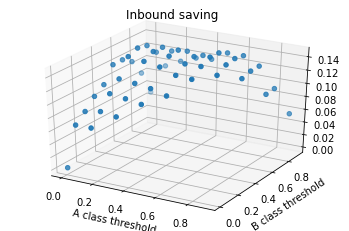

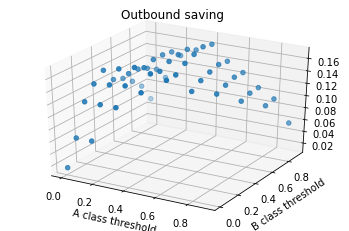

In [21]:
# %% calculate saving for different Pareto cuts
from logproj.P2_assignmentProblem.warehousing_ABC_saving import plotSavingABCclass
p =max(D_loc['LOCCODEX']) - min(D_loc['LOCCODEX']) #set warehouse front length
q =max(D_loc['LOCCODEY']) - min(D_loc['LOCCODEY']) # set warehouse depth 

figure_output=plotSavingABCclass(p,q,D_SKUs)
for key in figure_output.keys():
        figure_output[key].savefig(path_current+f"\\{key}.png") 
